In [278]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu
from copy import copy
from sklearn.model_selection import train_test_split


In [279]:
file_path = 'data//avito_new_data_for_dano.xlsx'

data = pd.read_excel(file_path)
data['CTR'] = data['page_views']
data['CR'] = data['contacts'] / data['page_views'] * 100
df = data

In [280]:
# Метод IQR для определения выбросов
Q1 = df['CR'].quantile(0.25)
Q3 = df['CR'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


D:\Программы\Temp\Temp\ipykernel_18456\3164049571.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['has_video'].replace({'ЛОЖЬ': 0, 'ИСТИНА': 1}, inplace=True)
D:\Программы\Temp\Temp\ipykernel_18456\3164049571.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, w

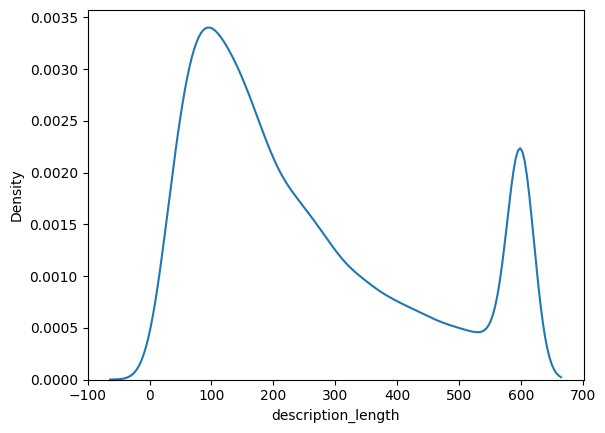

D:\Программы\Temp\Temp\ipykernel_18456\3164049571.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('bins').agg(median_y=(y, 'mean'), count=(y, 'size')).reset_index()


                  bins  median_y  count
0      (0.401, 20.967]  1.626675    439
1     (20.967, 40.933]  1.848286   1382
2       (40.933, 60.9]  1.843081   2255
3       (60.9, 80.867]  1.954347   2699
4    (80.867, 100.833]  1.661941   2928
5     (100.833, 120.8]  1.859008   2758
6     (120.8, 140.767]  1.803225   2561
7   (140.767, 160.733]  1.685555   2460
8     (160.733, 180.7]  1.639359   2079
9     (180.7, 200.667]  1.742084   1841
10  (200.667, 220.633]  1.635324   1603
11    (220.633, 240.6]  1.600666   1437
12    (240.6, 260.567]  1.662890   1396
13  (260.567, 280.533]  1.559942   1184
14    (280.533, 300.5]  1.474750   1093
15    (300.5, 320.467]  1.500410    926
16  (320.467, 340.433]  1.530064    855
17    (340.433, 360.4]  1.445693    772
18    (360.4, 380.367]  1.430741    671
19  (380.367, 400.333]  1.375720    644
20    (400.333, 420.3]  1.302313    594
21    (420.3, 440.267]  1.408157    530
22  (440.267, 460.233]  1.402525    505
23    (460.233, 480.2]  1.792866    450


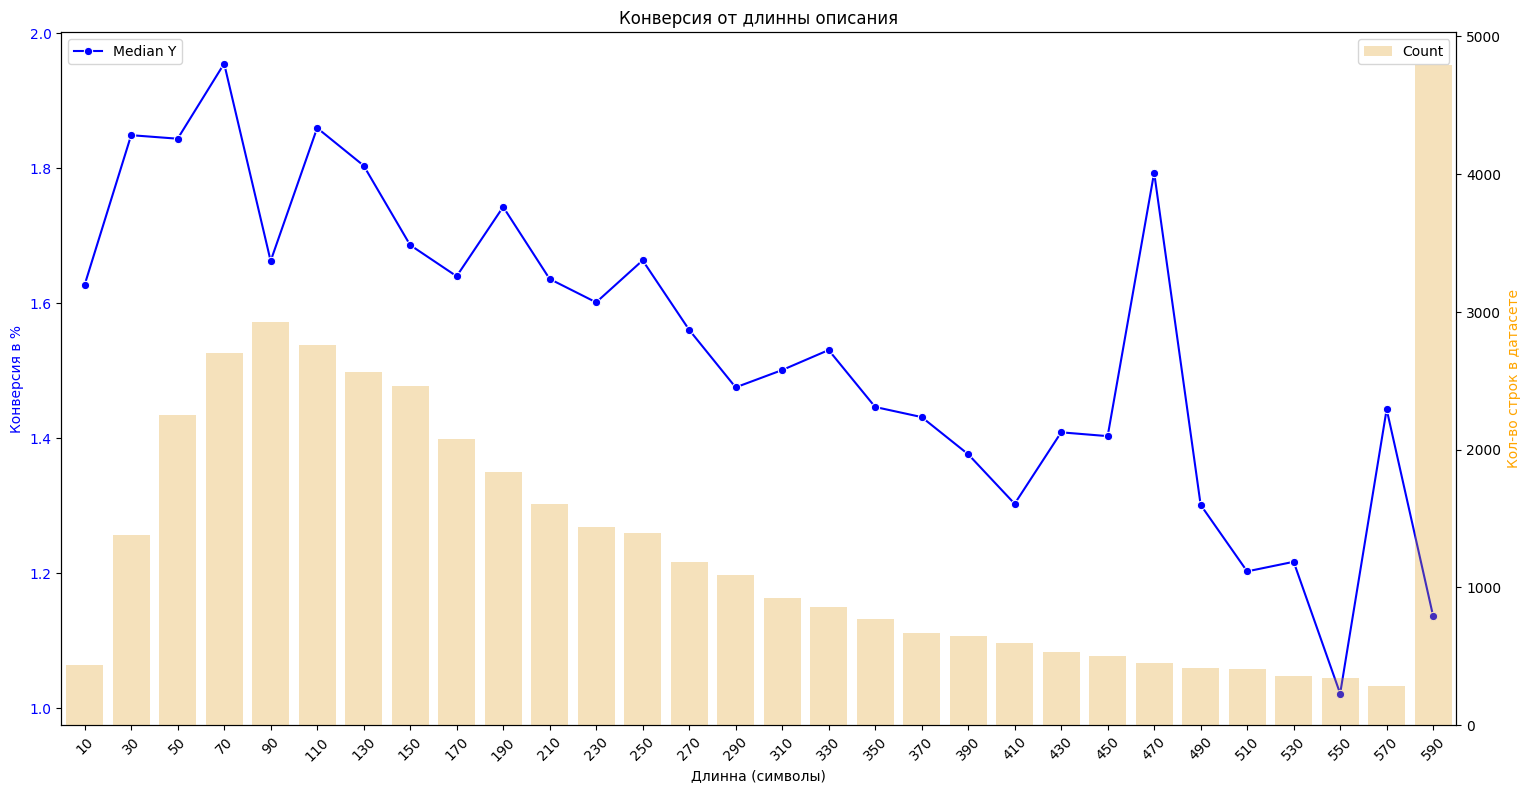

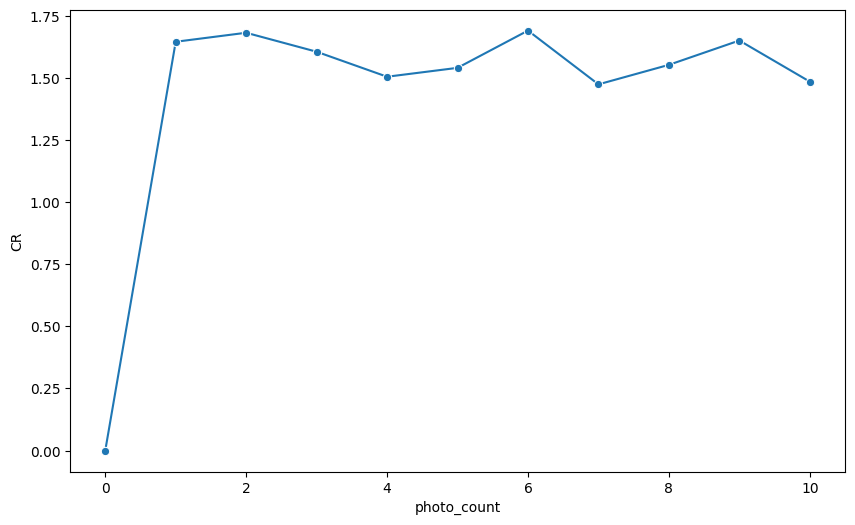

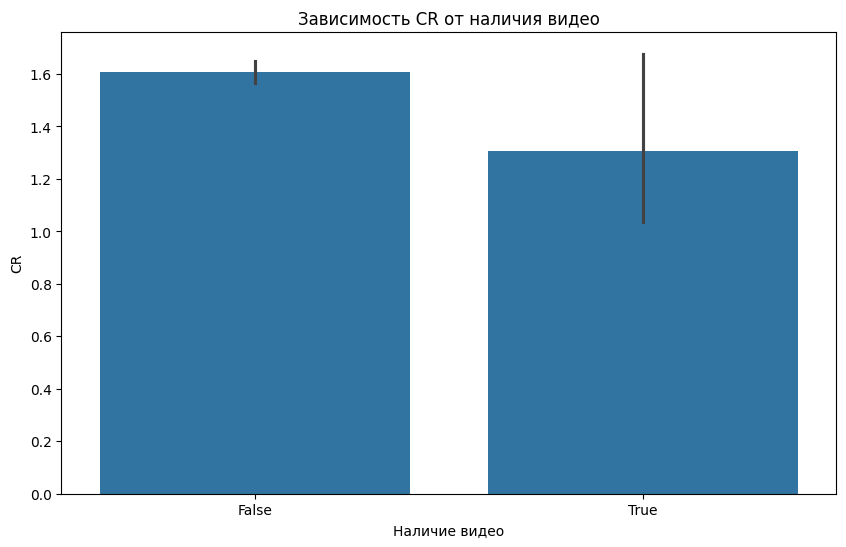

In [289]:
# Удаление NaN значений
df['has_video'].replace({'ЛОЖЬ': 0, 'ИСТИНА': 1}, inplace=True)
df = df.dropna(subset=['category', 'age', 'description_length', 'CTR', 'CR', 'has_video'])
df['CR'].replace([np.inf, -np.inf], 0, inplace=True)
sns.kdeplot(df['description_length'])
plt.show()
df['description_length'] = df['description_length'].clip(upper=600)
group_df = pd.DataFrame()

def plot_line(x, y, title, xlabel, ylabel, df=df, bins=20):

    # Создание интервалов для оси X
    df['x_bins'] = list(map(lambda x: x.right, pd.cut(df[x], bins=bins)))  # Разбиваем на интервалы
    # Вычисление среднего значения Y для каждого интервала
    median_data = df.groupby('x_bins')[y].mean().reset_index()  # Группировка и расчет среднего
    median_data = median_data.dropna()

    group_df['x_bins'] = median_data['x_bins']
    group_df['CR'] = median_data['CR']
    # Проверка на наличие данных в median_data
    if median_data.empty:
        print("Нет данных для построения графика.")
        return

    # Построение графика
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=median_data, x='x_bins', y=y, marker='o')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)  # Поворот меток по оси X для лучшей читаемости
    plt.show()


def plot_line_count(x, y, title, xlabel, ylabel, df=df, bins=20, kde=False):

    # Создание группировки по бинам
    df['bins'] = pd.cut(df[x], bins=bins)
    grouped = df.groupby('bins').agg(median_y=(y, 'mean'), count=(y, 'size')).reset_index()

    # Получение значений для оси X (центры бинов)
    bin_centers = grouped['bins'].apply(lambda x: x.mid)

    # Построение графиков
    fig, ax1 = plt.subplots(figsize=(18, 9))

    print(grouped.head(30))

    # График медианных значений
    sns.lineplot(x=range(len(bin_centers)), y=grouped['median_y'], ax=ax1, color='b', marker='o', label='Median Y')
    ax1.set_title(title)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel, color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.set_xticks(range(len(bin_centers)))
    ax1.set_xticklabels([f"{int(b.mid)}" for b in grouped['bins']], rotation=45)

    # Создание второго оси для количества значений
    ax2 = ax1.twinx()
    sns.barplot(x=range(len(bin_centers)), y=grouped['count'], ax=ax2, color='orange', alpha=0.3, label='Count')
    ax2.set_ylabel('Кол-во строк в датасете', color='orange')
    ax2.tick_params(axis='y')
    ax2.set_xticks(range(len(bin_centers)))
    ax2.set_xticklabels([f"{int(b.mid)}" for b in grouped['bins']], rotation=45)

    # Добавление легенды
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.show()

plot_line_count('description_length', 'CR', 'Конверсия от длинны описания', 'Длинна (символы)', 'Конверсия в %', df, bins=30)

plt.figure(figsize=(10, 6))
sns.lineplot(data=df.groupby('photo_count')['CR'].mean().reset_index(), x='photo_count', y='CR', marker='o')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='has_video', y='CR')
plt.title('Зависимость CR от наличия видео')
plt.xlabel('Наличие видео')
plt.ylabel('CR')
plt.show()

In [282]:
import statsmodels.api as sm


df2 = data
df2['has_video'].replace({'ЛОЖЬ': 0, 'ИСТИНА': 1}, inplace=True)
df2['CR'].replace([np.inf, -np.inf], 0, inplace=True)
df2 = df2.dropna(subset=['category', 'age', 'description_length', 'CTR', 'CR', 'has_video'])

X = df2[['description_length', 'photo_count', 'has_video']].astype(int) # Независимые переменные
Y = df2['CR'] # Зависимая переменная

# Добавляем константу к независимым переменным
X = sm.add_constant(X)

# Создаем модель OLS
model = sm.OLS(Y, X)

# Подгоняем модель
results = model.fit()

# Выводим результаты
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                     CR   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     36.36
Date:                Mon, 16 Dec 2024   Prob (F-statistic):           1.86e-23
Time:                        01:38:07   Log-Likelihood:            -1.1599e+05
No. Observations:               40660   AIC:                         2.320e+05
Df Residuals:                   40656   BIC:                         2.320e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  1.7764      0

D:\Программы\Temp\Temp\ipykernel_18456\828524488.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['has_video'].replace({'ЛОЖЬ': 0, 'ИСТИНА': 1}, inplace=True)
D:\Программы\Temp\Temp\ipykernel_18456\828524488.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, wh